In [ ]:
""" LOAD PROCESSED DATA """
import pandas as pd
import os, zipfile, glob
import pandas as pd
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

df_before = pd.read_parquet("/content/drive/MyDrive/retrofit_processed/df_before.parquet")
df_after  = pd.read_parquet("/content/drive/MyDrive/retrofit_processed/df_after.parquet")

print("Reloaded shapes:", df_before.shape, df_after.shape)

In [3]:
""" FEATURE PREP """
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import math

# dataset
df = df_before.copy()

# take revelant features
features = [
    "Timestamp",
    "Outdoor_Temp_C",
    "Outdoor_RH_Percent",
    "Solar_Radiation_DNI_W_m2",
    "Wind_Speed_MPH",
    "Indoor_Temperature_C",
    "Indoor_RH_Percent",
    "HVAC_Energy_usage_KWh"
]
df = df[features].copy()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# resample hourly
df = df.resample("1h", on="Timestamp").mean().dropna().reset_index()

# take time features and cyclical encoding
df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

# add lag features
for lag in range(1, 25):
    df[f"HVAC_lag_{lag}"] = df["HVAC_Energy_usage_KWh"].shift(lag)
df = df.dropna().reset_index(drop=True)

# final features
final_features = [
    "Outdoor_Temp_C",
    "Outdoor_RH_Percent",
    "Solar_Radiation_DNI_W_m2",
    "Wind_Speed_MPH",
    "Indoor_Temperature_C",
    "Indoor_RH_Percent",
    "hour", "dayofweek", "is_weekend",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos"
] + [f"HVAC_lag_{lag}" for lag in range(1, 25)]

target = "HVAC_Energy_usage_KWh"

# scale features
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(df[final_features])
y_scaled = y_scaler.fit_transform(df[[target]])




In [ ]:
""" LSTM MODEL IMPLEMENTATION """

# create sequence for learning
def create_sequences(X, y, time_steps=72):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 72
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# train/val/test split
n = len(X_seq)
train_size = int(n * 0.7)
val_size = int(n * 0.15)

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# define model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2), input_shape=(TIME_STEPS, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# define callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# training loop
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# evaluation
y_pred_scaled = model.predict(X_test)
y_test_real = y_scaler.inverse_transform(y_test)
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = math.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print("Test Results:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R²   = {r2:.3f}")

# plot predictions
plt.figure(figsize=(12,5))
plt.plot(y_test_real, label="Actual", alpha=0.8)
plt.plot(y_pred_real, label="Predicted", alpha=0.8)
plt.title("Bidirectional LSTM HVAC Energy Forecasting")
plt.xlabel("Time steps (test set)")
plt.ylabel("HVAC Energy usage (KWh)")
plt.legend()
plt.show()

In [ ]:
# Save model after training
model.save("/content/drive/MyDrive/hvac_lstm_model.keras")


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step
Test Results:
MAE  = 0.001
RMSE = 0.002
R²   = 0.850


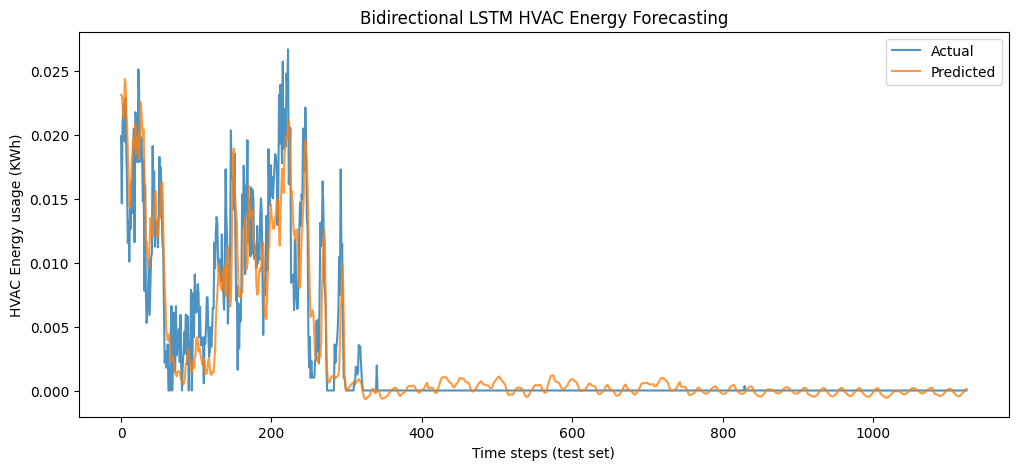

In [ ]:
""" MODEL EVALUATION """
y_pred_scaled = model.predict(X_test)
y_test_real = y_scaler.inverse_transform(y_test)
y_pred_real = y_scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = math.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print("Test Results:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R²   = {r2:.3f}")

# plot predictions
plt.figure(figsize=(12,5))
plt.plot(y_test_real, label="Actual", alpha=0.8)
plt.plot(y_pred_real, label="Predicted", alpha=0.8)
plt.title("Bidirectional LSTM HVAC Energy Forecasting")
plt.xlabel("Time steps (test set)")
plt.ylabel("HVAC Energy usage (KWh)")
plt.legend()
plt.show()